In [ ]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
df = pd.read_csv('database.csv') # read earthquake dataset

In [ ]:
#check the first five rows of data
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [ ]:
def preprocess_input(df):
    df = df.copy()
    # dropping ID as its an unrelevant feature.
    df.drop('ID', axis=1,inplace=True)
    # checking for features in which greater than 66%(2/3) of data is missing
    null_columns = df.loc[:, df.isna().sum() > 0.66 * df.shape[0]].columns
    # dropping those columns
    df.drop(null_columns, axis=1,inplace=True)
    # filling missing values by substituting mean value in rms columns
    df['Root Mean Square'] = df['Root Mean Square'].fillna(df['Root Mean Square'].mean())
    # filling missing values by substituting mode in Magnitude type columns
    df['Magnitude Type'] = df['Magnitude Type'].fillna(df['Magnitude Type'].mode()[0])
    df.reset_index(drop=True,inplace=True)
    # converting Date into pandas datetime
    df['Date'] = pd.to_datetime(df['Date'],utc=True)
    # converting Time into pandas datetime
    df['Time'] = pd.to_datetime(df['Time'],utc=True)
    # Extracting Year and Month From Date column and converting it into integer
    df['Year'] = df['Date'].apply(lambda x: str(x)[0:4]).astype(np.int)
    df['Month'] = df['Date'].apply(lambda x: str(x)[5:7]).astype(np.int)
    # Extracting Hour From Time column and converting it into integer
    df['Hour'] = df['Time'].apply(lambda x: str(x)[11:13]).astype(np.int)

    # dropping Date and Time as we dont need data anymore.
    df.drop(['Date','Time'], axis=1,inplace=True)

    # encoding Status to make data numerical.
    df['Status'] = df['Status'].map({'Automatic':0,
                                    'Reviewed':1}).astype('int')

    return df

In [ ]:
df = preprocess_input(df)

<ipython-input-8-c9727ed63b0f>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['Year'] = df['Date'].apply(lambda x: str(x)[0:4]).astype(np.int)
<ipython-input-8-c9727ed63b0f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

In [ ]:
# check missing values again.
df.isnull().sum()

Latitude            0
Longitude           0
Type                0
Depth               0
Magnitude           0
Magnitude Type      0
Root Mean Square    0
Source              0
Location Source     0
Magnitude Source    0
Status              0
Year                0
Month               0
Hour                0
dtype: int64

In [ ]:
#create list of categorical columns for one hot encoding
categorical_columns = [col for col in df.columns if df.dtypes[col] == 'object']

#create list of numerical columns to standardized data
numerical_columns = [col for col in df.columns if ((df.dtypes[col] != 'object') & (col != 'Status'))]

print('Numerical Features are : ',numerical_columns)
print('Categorical Features are : ',categorical_columns)

Numerical Features are :  ['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Root Mean Square', 'Year', 'Month', 'Hour']
Categorical Features are :  ['Type', 'Magnitude Type', 'Source', 'Location Source', 'Magnitude Source']


In [ ]:
#one hot encoding for categorical features
def onehot_encoder(df, cols):
    df = df.copy()
    for col in cols:
        dummies = pd.get_dummies(df[col], drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1,inplace=True)
    return df

In [ ]:
df = onehot_encoder(df,categorical_columns)

In [ ]:
sc = StandardScaler()
df[numerical_columns] = sc.fit_transform(df[numerical_columns])

In [ ]:
df.head()

,Latitude,Longitude,Depth,Magnitude,Root Mean Square,Status,Year,Month,Hour,Explosion,...,NN,OFFICIAL,PAR,PGC,PR,SE,US,US_GCMT,US_PGC,UW
0,0.583377,0.844368,0.495984,0.277668,1.367985e-15,0,-1.915487,-1.603109,0.225244,0,...,0,0,0,0,0,0,0,0,0,0
1,0.006109,0.698849,0.075272,-0.195082,1.367985e-15,0,-1.915487,-1.603109,-0.064982,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.739162,-1.701962,-0.413928,0.750418,1.367985e-15,0,-1.915487,-1.603109,0.950811,0,...,0,0,0,0,0,0,0,0,0,0
3,-2.017599,-0.503524,-0.454694,-0.195082,1.367985e-15,0,-1.915487,-1.603109,0.950811,0,...,0,0,0,0,0,0,0,0,0,0
4,0.340688,0.691479,-0.454694,-0.195082,1.367985e-15,0,-1.915487,-1.603109,0.225244,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df.drop('Status',axis=1)
y = df['Status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [ ]:
#Create a `Sequential` model and add a Dense layer as the first layer.
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
# Now the model will take as input arrays of shape about (None, 104)
# and output arrays of  about (None, 32).
# we can note that after the first layer, you don't need to specify
# the size of the input anymore:
model.add(Dense(64, activation='relu'))
# Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('Automatic')
# and 1 for the other ('Reviewed')
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
#The following is the model summary of the model:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3296      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,473
Trainable params: 5,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Early Stopping
monitor = EarlyStopping(monitor='val_auc', patience=5,
                        verbose=1, mode='max',restore_best_weights=True)
# Defining Callbacks for the model

filepath = './best_weights.hdf5'
checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

reduceLR = ReduceLROnPlateau()
callback_list = [monitor, checkpoint,reduceLR]

# model compile
model.compile(
    optimizer=Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=25,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/25
410/410 [==============================] - ETA: 0s - loss: 0.0726 - auc: 0.9957
Epoch 1: val_auc improved from -inf to 1.00000, saving model to ./best_weights.hdf5
410/410 [==============================] - 5s 6ms/step - loss: 0.0726 - auc: 0.9957 - val_loss: 0.0017 - val_auc: 1.0000 - lr: 0.0010
Epoch 2/25
393/410 [===========================>..] - ETA: 0s - loss: 6.3364e-04 - auc: 1.0000
Epoch 2: val_auc did not improve from 1.00000
410/410 [==============================] - 1s 3ms/step - loss: 6.1444e-04 - auc: 1.0000 - val_loss: 3.6456e-04 - val_auc: 1.0000 - lr: 0.0010
Epoch 3/25
399/410 [============================>.] - ETA: 0s - loss: 1.4516e-04 - auc: 1.0000
Epoch 3: val_auc did not improve from 1.00000
410/410 [==============================] - 1s 3ms/step - loss: 1.4419e-04 - auc: 1.0000 - val_loss: 1.4742e-04 - val_auc: 1.0000 - lr: 0.0010
Epoch 4/25
393/410 [===========================>..] - ETA: 0s - loss: 6.5169e-05 - auc: 1.0000
Epoch 4: val_auc did not impro

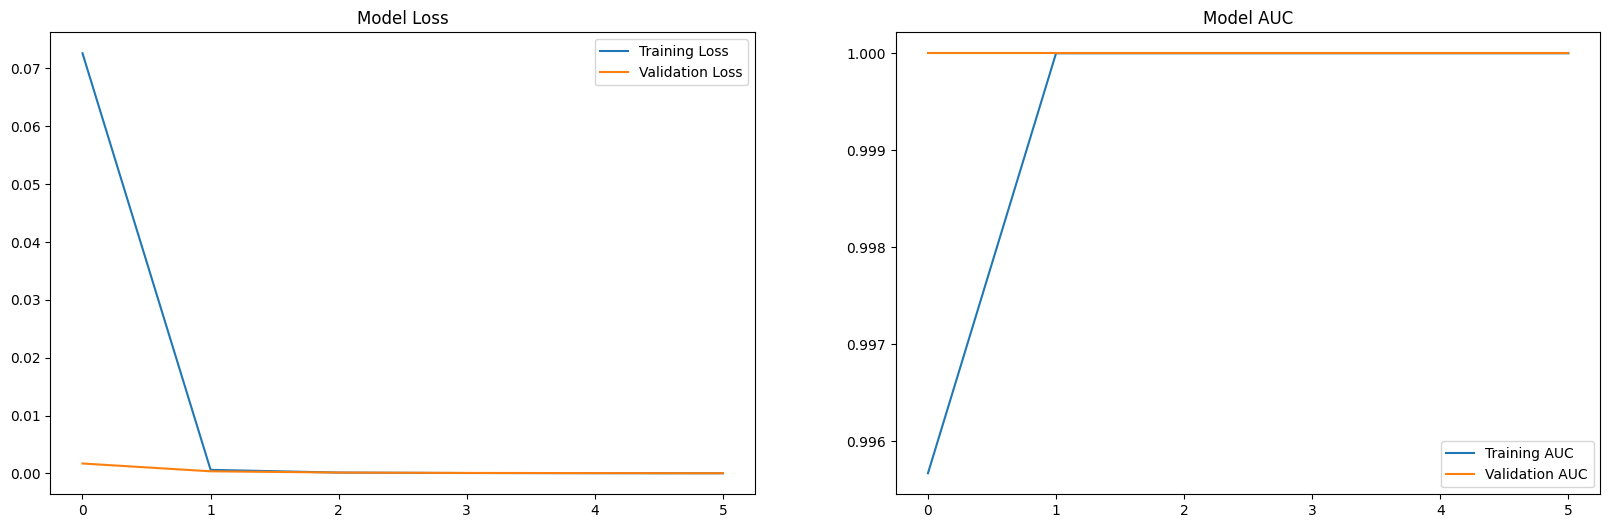

In [ ]:
plt.figure(figsize=(20, 6))

train_loss, val_loss = history.history['loss'], history.history['val_loss']
train_auc, val_auc = history.history['auc'], history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Model Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label="Training AUC")
plt.plot(history.history['val_auc'], label="Validation AUC")
plt.legend()
plt.title("Model AUC")

plt.show()

In [ ]:
model.evaluate(X_test, y_test)

220/220 [==============================] - 1s 4ms/step - loss: 0.0014 - auc: 1.0000


[0.0013847395312041044, 1.0]

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

220/220 [==============================] - 1s 2ms/step


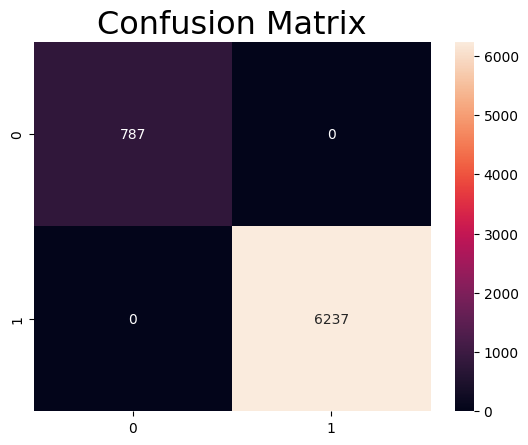

In [ ]:
cf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix,annot=True,fmt="d")
plt.title('Confusion Matrix', fontsize = 23)
plt.show()

In [ ]:
y_test.value_counts()

1    6237
0     787
Name: Status, dtype: int64

In [ ]:
import pickle
# dump : put the data of the object in a file
with open('model', 'wb') as f:
  pickle.dump(model, f)

In [3]:
# upload in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
